## Load Dataset

In [1]:
import os
import diffusers
import torch

import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt

from urllib.request import urlopen 
import json 

os.environ['HF_HOME'] = "/run/media/anton/hdd/hf"

In [2]:
from diffusers import DiffusionPipeline
import PIL.Image
import numpy as np

from datasets import load_dataset

dataset = load_dataset("uoft-cs/cifar10", split="train")

/home/anton/source/torch-env/lib/python3.12/site-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)


In [3]:
from torchvision import transforms

batch_size=32

preprocess = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5]),
        ]
    )

def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["img"]]
    return {"images": images}

dataset.set_transform(transform)
train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

## Define VAE Model

In [4]:
from diffusers.models import AutoencoderKL

model = AutoencoderKL(
    in_channels=3,  
    out_channels=3,  
    latent_channels=4,
    layers_per_block=2,  
    block_out_channels=(64, 64, 64, 64,),  # the number of output channels for each UNet block
    down_block_types=(
        "DownEncoderBlock2D",
        "DownEncoderBlock2D",
        "DownEncoderBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownEncoderBlock2D",
    ),
    up_block_types=(
        "UpDecoderBlock2D",  # a regular ResNet upsampling block
        "UpDecoderBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpDecoderBlock2D",
        "UpDecoderBlock2D",
    ),
)

In [5]:
from diffusers.optimization import get_constant_schedule
from accelerate import Accelerator

lr=1e-4
epochs=100


optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

lr_scheduler = get_constant_schedule(optimizer=optimizer)

accelerator = Accelerator(mixed_precision="fp16", gradient_accumulation_steps=1)

model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
    model, optimizer, train_dataloader, lr_scheduler
)

In [6]:
batch = next(iter(train_dataloader))

In [7]:
x = batch['images']

q = model.encode(x).latent_dist

loss_kl = -0.5 * torch.sum(1 + q.logvar - q.mean.pow(2) - q.logvar.exp())

x_pred = model.decode(q.sample()).sample

loss_recon = torch.nn.functional.mse_loss(x_pred, x)

loss = loss_recon + loss_kl


In [9]:
import torch.nn.functional as F

for epoch in range(epochs):
    for batch_idx, batch in enumerate(train_dataloader):

        x = batch['images']
        
        with accelerator.accumulate(model):
            q = model.encode(x).latent_dist

            # loss_kl = -0.5 * torch.sum(1 + q.logvar - q.mean.pow(2) - q.logvar.exp())
            loss_kl = q.kl().mean()
            
            x_pred = model(x).sample
            
            loss_recon = F.mse_loss(x_pred, x)
            
            loss = loss_recon + loss_kl
            
            accelerator.backward(loss)

            accelerator.clip_grad_norm_(model.parameters(), 1.0)
            
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
        
        if batch_idx % 100 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Step [{batch_idx+1}/{len(train_dataloader)}], Loss: {loss.item():.4f}')

Epoch [1/100], Step [1/1563], Loss: 3.7707
Epoch [1/100], Step [101/1563], Loss: 0.2453
Epoch [1/100], Step [201/1563], Loss: 0.1850
Epoch [1/100], Step [301/1563], Loss: 0.1702
Epoch [1/100], Step [401/1563], Loss: 0.1229
Epoch [1/100], Step [501/1563], Loss: 0.1161
Epoch [1/100], Step [601/1563], Loss: 0.1060
Epoch [1/100], Step [701/1563], Loss: 0.0943
Epoch [1/100], Step [801/1563], Loss: 0.0974
Epoch [1/100], Step [901/1563], Loss: 0.1065
Epoch [1/100], Step [1001/1563], Loss: 0.1068
Epoch [1/100], Step [1101/1563], Loss: 0.0825
Epoch [1/100], Step [1201/1563], Loss: 0.0948
Epoch [1/100], Step [1301/1563], Loss: 0.0861
Epoch [1/100], Step [1401/1563], Loss: 0.0816
Epoch [1/100], Step [1501/1563], Loss: 0.1042
Epoch [2/100], Step [1/1563], Loss: 0.0921
Epoch [2/100], Step [101/1563], Loss: 0.0860
Epoch [2/100], Step [201/1563], Loss: 0.0757
Epoch [2/100], Step [301/1563], Loss: 0.0775
Epoch [2/100], Step [401/1563], Loss: 0.0697
Epoch [2/100], Step [501/1563], Loss: 0.0723
Epoch [2

KeyboardInterrupt: 

## inference

In [10]:
batch = next(iter(train_dataloader))['images']

In [11]:
model(batch).sample

tensor([[[[-6.1035e-01, -6.8164e-01, -6.8750e-01,  ..., -6.3770e-01,
           -6.2842e-01, -5.7715e-01],
          [-6.5771e-01, -6.7969e-01, -7.0020e-01,  ..., -6.2744e-01,
           -6.2744e-01, -6.3867e-01],
          [-6.8359e-01, -6.8262e-01, -6.8994e-01,  ..., -6.2402e-01,
           -6.4697e-01, -6.6455e-01],
          ...,
          [-8.1152e-01, -7.8662e-01, -7.8027e-01,  ..., -6.6602e-01,
           -6.8262e-01, -6.9287e-01],
          [-7.8613e-01, -7.6514e-01, -7.6660e-01,  ..., -6.6113e-01,
           -6.5869e-01, -6.7578e-01],
          [-7.1924e-01, -7.3633e-01, -7.5000e-01,  ..., -6.6357e-01,
           -6.5967e-01, -6.3721e-01]],

         [[-4.4946e-01, -5.3125e-01, -5.8301e-01,  ..., -4.6777e-01,
           -4.6802e-01, -4.1406e-01],
          [-5.3564e-01, -5.6934e-01, -5.8350e-01,  ..., -4.8071e-01,
           -4.8413e-01, -4.7705e-01],
          [-5.4443e-01, -5.6201e-01, -5.7666e-01,  ..., -4.5557e-01,
           -4.7632e-01, -5.0293e-01],
          ...,
     

In [12]:
batch_dec = model(batch).sample


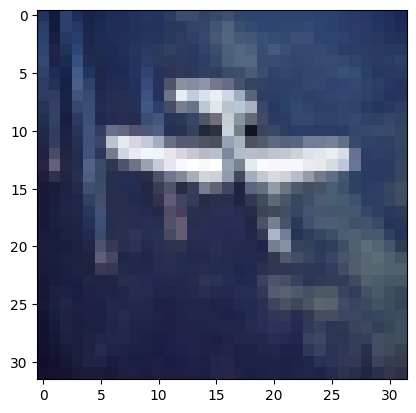

In [13]:
plt.imshow(
    np.moveaxis(batch[0].cpu().numpy() / 2 + 0.5, 0, -1)
)

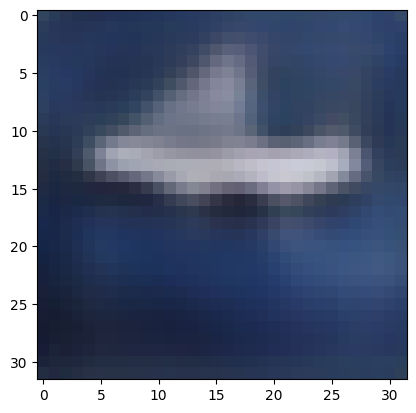

In [14]:
plt.imshow(
    np.moveaxis(batch_dec[0].cpu().detach().numpy() / 2 + 0.5, 0, -1)
)